# Is there any difference between the proportions of high-school regular smokers in British Columbia and Ontario?

In [1]:
library(tidyverse)
library(haven)
library(infer)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.8
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

Warning message:
“package ‘tidyr’ was built under R version 4.1.2”
Warning message:
“package ‘readr’ was built under R version 4.1.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Introduction

#### Why we're interested in the topic
Smoking becomes a common phenomenon among teenagers even though they know the negative effects of it. The prevalence of tobacco products makes it both more tempting to try and harder to quit for teenagers (Burton et al.). Scholars studying student smoking rates in ON (Reitsma and Manske) and BC (Johnson et al.) claim that the issue needs more attention as it causes severe health problems. Hence, our research analyses the problem by finding the **difference between the proportions of high-school regular smokers in British Columbia and Ontario**.

Most smokers aware the negative effects of smoking. But there are many physical and environmental factors which are stopping them from quitting smoking. From physical side many of the ingredients in tobacco are addictive, causing a physiological demand for these ingredients. For the environmental part, smokers who want to quit smoking are very likely to they are easily contacted by tobacco in their daily life. For example, they can see others smoking or smell the cigarettes. These then fantasize about their desire for cigarettes and shake their resolve to quit. However, the number of ex-smokers will not decrease because fewer people taking up smoking (Burton et al.).

#### Our data set
We use the data obtained from a biennial school-based Health Canada's survey constructed in 2018/2019 that the studies smoking rates among Canadian students (Canada and Impact).

#### Variables
The variables we choose are aimed at defining our custom variable that determines whether a data set observation is a high-school student who is a regular smoker. Using these parameters, we can filter our dataset to only contain the population we are interested in so that we can then do further calculations on its proportions.

The Variable names are the ones obtained directly from the dataset

| Variable   	| Value   	| Meaning                                                 	|
|------------	|---------	|---------------------------------------------------------	|
| **GRADE**  	| [9, 12] 	| student is from a grade 9-12                            	|
| **DVRES**  	| 1 or 3  	| resident of Canada or has lived in Canada for 11+ years 	|
| **TS_011** 	| 1 or 2  	| will smoke a cigarette within next year                 	|
| **TV_010** 	| 1 or 2  	| will use an e-cigarette within next year                	|
| **SS_040** 	| 1       	| has smoked 100+ cigarettes                              	|
| **SS_060** 	| 7 or 8  	| has smoked 20-30 cigarettes during the last 30 days     	|
| **WP_030** 	| 3 or 6  	| has smoked every day in the past week                   	|

#### Reasons for choice of variable
* **GRADE** and **DVRES** are used to select the population that we are interested in (Canadian High-Schoolers).
* **TS_011** and **TV_010** show that the students are intending to smoke within the next year which would be a characteristic of a regular smoker.
* **SS_040**, **SS_060**, and **WP_030** all show that the given individual has a history of smoking at a regular pace.
 


## Methods

#### Why our research is reliable
* Data is from 2018-2019, so it is timely
* Data set has many variables, so we can precisely define our "regular smoker" variable

#### Calculation procedures for the final report
We're conducting a hypothesis test of the difference between the proportions of high-school smoking students in BC and ON. Here's an outline:
* Find point estimate
* Use bootstrapping to create sampling distribution
* Conduct hypothesis test using p-value
    * Plot the bootstrap distribution with the p-value
    * Decide on the rejection of H<sub>0</sub>
* Conduct hypothesis test using CI
    * Plot the bootstrap distribution with the CI endpoints
* Compare the results of the p-value and CI approaches
    
Below we calculate the point estimate, i.e., we do the first step in the plan.

## Preliminary Data Analysis (344 words)

#### Reading the data

In [2]:
# Reading the data and presenting the first few rows of it as a table
data <- read_sav("./data/dataset.sav")
data %>%
  head()

SCANID,MODULE,PROVID,SCHID,GRADE,SEX,SS_010,SS_020,TS_011,TV_010,⋯,DVTY2ST,DVLAST30,DVAMTSMK,DVCIGWK,DVNDSMK,DVAVCIGD,DVRES,DVURBAN,DVHHINC2,WTPP
<dbl>,<dbl+lbl>,<dbl+lbl>,<dbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,⋯,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl+lbl>,<dbl>,<dbl>
100224,1,35,3589267,9,1,1,13,2,3,⋯,1,1,1,8,5,2,1,2,60000,33.15
100225,1,35,3589267,9,1,1,13,1,1,⋯,1,1,10,70,7,10,1,2,60000,33.15
100226,1,35,3589267,12,1,2,NA,4,3,⋯,7,2,NA,NA,NA,NA,3,2,60000,75.14
100227,1,35,3589267,12,2,1,NA,3,2,⋯,4,1,0,0,0,0,1,2,60000,105.70
100228,1,35,3589267,12,1,1,NA,3,3,⋯,6,2,NA,NA,NA,NA,1,2,60000,75.14
100229,1,35,3589267,11,1,2,NA,4,3,⋯,7,2,NA,NA,NA,NA,1,2,60000,63.87


#### Exploratory analysis

As described above, we're going to study students from BC and ON and use the derived categorical variable called `regular_smoker`. This boolean variable can be `yes` or `no`, which specifies whether the observed high-school student is a regular smoker

In [3]:
# Using the "Variables" section table values,
# this code creates a new column `regular_smoker` and
# filters the data set to contain only observations of BC and ON students

tidy_data <- data %>%
  filter(GRADE %in% 9:12,
         PROVID == 35 | PROVID == 59) %>%
  mutate(regular_smoker = if_else(
    ((DVRES == 1 | DVRES == 3) &
      (TS_011 %in% 1:2) &
      (TV_010 %in% 1:2) &
      (SS_040 == 1) &
      (SS_060 %in% 7:8) &
      (WP_030 == 3 | WP_030 == 6)),
    "yes", "no"
  )) %>%
  filter(!is.na(regular_smoker)) %>%
  mutate(province = as_factor(PROVID),
         grade = as_factor(GRADE)) %>%
  arrange(province) %>%
  select(province, grade, regular_smoker)

tidy_data %>%
  tail(3)

province,grade,regular_smoker
<fct>,<fct>,<chr>
British Columbia,Grade 10,no
British Columbia,Grade 10,no
British Columbia,Grade 10,no


We can also find how many observations our filtered data set has.

In [4]:
tidy_data %>%
  group_by(province) %>%
  summarise(obs_count = n())

province,obs_count
<fct>,<int>
Ontario,2805
British Columbia,4377


The sample size is sufficiently large, but we don't trim it to have same number of observations in each category. The higher number of observations would only improve our analysis as the obtained sample would be more representative of the population. Referring to the data-collection procedure above, we also assume that this sample is not biased, and therefore we can proceed with the analysis.

Now we visualize our obtained data to visually estimate the difference in the proportion of smoking students.

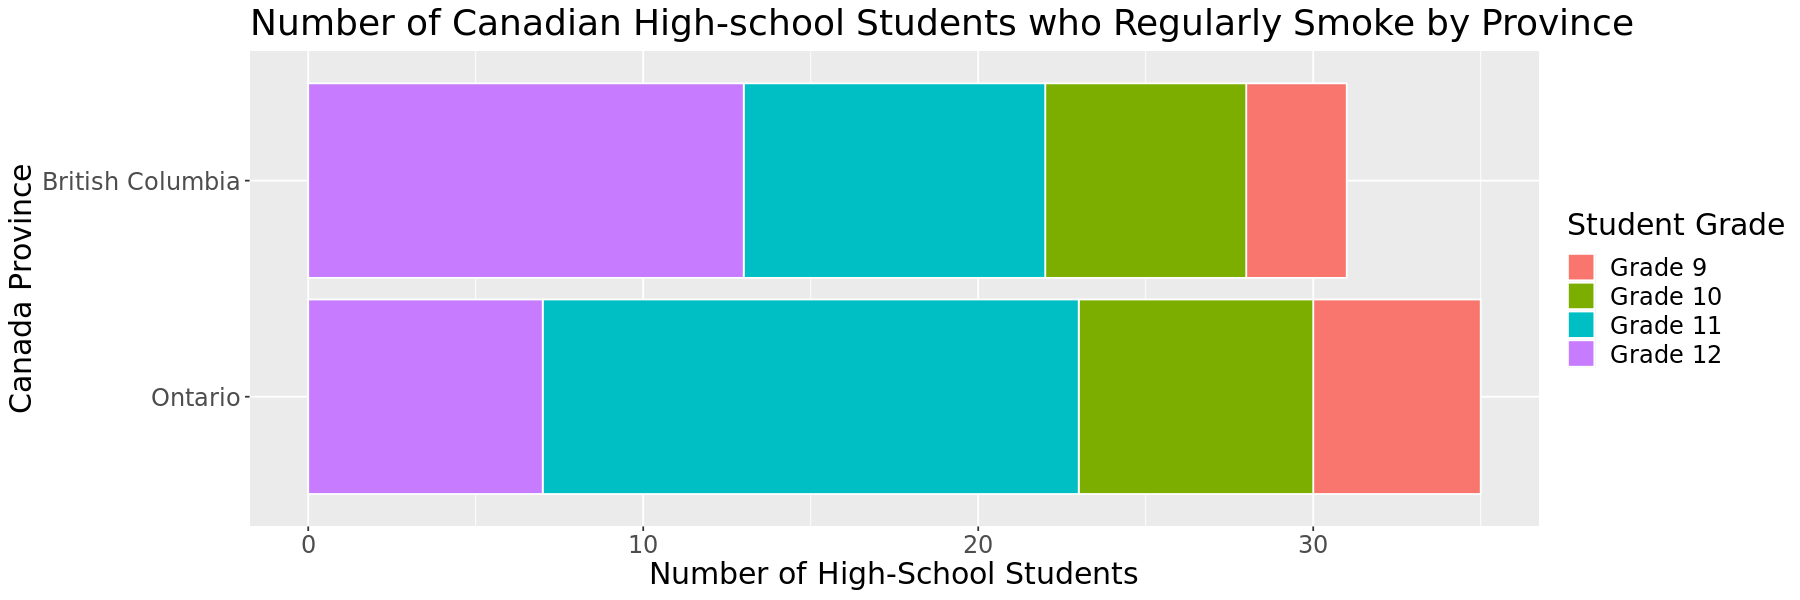

In [5]:
options(repr.plot.width = 15, repr.plot.height = 5)

# The bar chart is colored by the `grade` variable
# to allow us to get a further insight into the data

tidy_data %>%
  filter(regular_smoker == "yes") %>%
  ggplot(aes(x = province, fill = grade)) +
  geom_bar(color = "white") +
  labs(title = "Number of Canadian High-school Students who Regularly Smoke by Province",
       x = "Canada Province",
       y = "Number of High-School Students",
       fill = "Student Grade") +
  coord_flip() +
  theme(text = element_text(size = 18))

The chart tells us that in BC and ON, high-school students are involved in smoking regardless of their grade. Also, it shows that the proportion in ON is a bit larger, so we infer that our point estimate is going to be positive but close to 0.

#### Point estimate calculation

From this point on, we don't consider `grade` as a variable because we're interested in studying all BC and ON high-school students in general. This approach inevitable introduces some ambiguity, but we think the "high-school student" term is specific enough for our study.

In [6]:
# Removes the `grade` column
sample <- tidy_data %>%
  select(-grade)

# Shows all possible combinations of our data set rows
sample %>%
  distinct()

province,regular_smoker
<fct>,<chr>
Ontario,no
Ontario,yes
British Columbia,no
British Columbia,yes


Next, we need to find the proportions of regular smokers in each province.

In [7]:
# We group our data set by the `province` variable and
# calculate the proportion of observations that have `regular_smoker` variable set to `yes`

# Here we use the mean function to quickly calculate the needed proportions
sample_proportions <- sample %>%
  group_by(province) %>%
  summarise(prop = mean(regular_smoker == "yes"))
sample_proportions

province,prop
<fct>,<dbl>
Ontario,0.012477718
British Columbia,0.007082477


Finally, the code below finds the point estimate by subtracting **the BC proportion from the ON proportion**, i.e., **p̂ = p<sub><sub>ON</sub></sub> - p<sub><sub>BC</sub></sub>**

In [9]:
point_estimate <- 
  sample_proportions$prop[1] - sample_proportions$prop[2]

point_estimate

[1] 0.005395242

## Hypothesis testing (diff in prop)

Let p1 be the proportion of high-school regular smokers in British Columbia, and let p2 be the proportion of high-school regular smokers in Ontario.

Null hypothesis: British Columbia and Ontario have the same proportion of high-school regular smokers (p1 = p2). 

Alternative hypothesis: There is a difference of the proportion of high-school regular smokers between British Columbia and Ontario (p1 != p2).

In [13]:
obs_diff_prop <- sample %>%
specify(formula = regular_smoker ~ province, success = "yes") %>%
calculate(stat = "diff in props", order = c("Ontario", "British Columbia"))
obs_diff_prop

Dropping unused factor levels c("Newfoundland and Labrador", "Prince Edward Island", "Nova Scotia", "New Brunswick", "Québec", "Manitoba", "Saskatchewan", "Alberta") from the supplied explanatory variable 'province'.



stat
<dbl>
0.005395242


In [14]:
null_distribution <- sample %>%
specify(formula = regular_smoker ~ province, success = "yes") %>%
hypothesize(null = "independence") %>%
generate(reps = 2000, type = "permute") %>%
calculate(stat = "diff in props", order = c("Ontario", "British Columbia"))
head(null_distribution)

Dropping unused factor levels c("Newfoundland and Labrador", "Prince Edward Island", "Nova Scotia", "New Brunswick", "Québec", "Manitoba", "Saskatchewan", "Alberta") from the supplied explanatory variable 'province'.



replicate,stat
<int>,<dbl>
1,0.0007154560
2,-0.0016244369
3,-0.0004544905
4,0.0030553489
5,-0.0004544905
6,0.0007154560


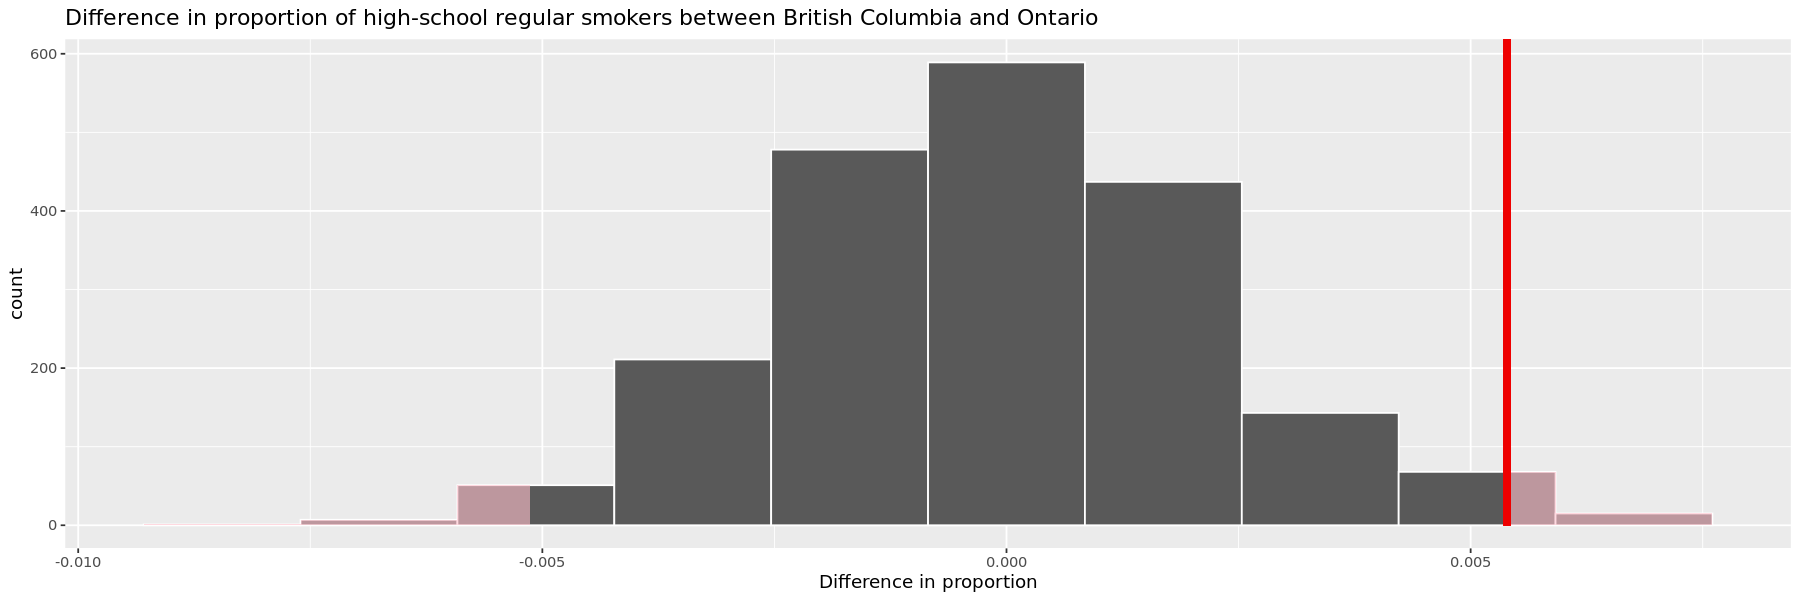

In [15]:
null_result_plot <- visualize(null_distribution, bins = 10) +
shade_p_value(obs_stat = point_estimate, direction = "both") +
xlab("Difference in proportion") +
ggtitle("Difference in proportion of high-school regular smokers between British Columbia and Ontario")
null_result_plot

In [17]:
p_value <- null_distribution %>%
get_p_value(obs_stat = point_estimate, direction = "both")
p_value

p_value
<dbl>
0.028


In [19]:
percentile_ci <- null_distribution %>%
get_confidence_interval(level = 0.95, type = "percentile")
percentile_ci

lower_ci,upper_ci
<dbl>,<dbl>
-0.004549303,0.004225295


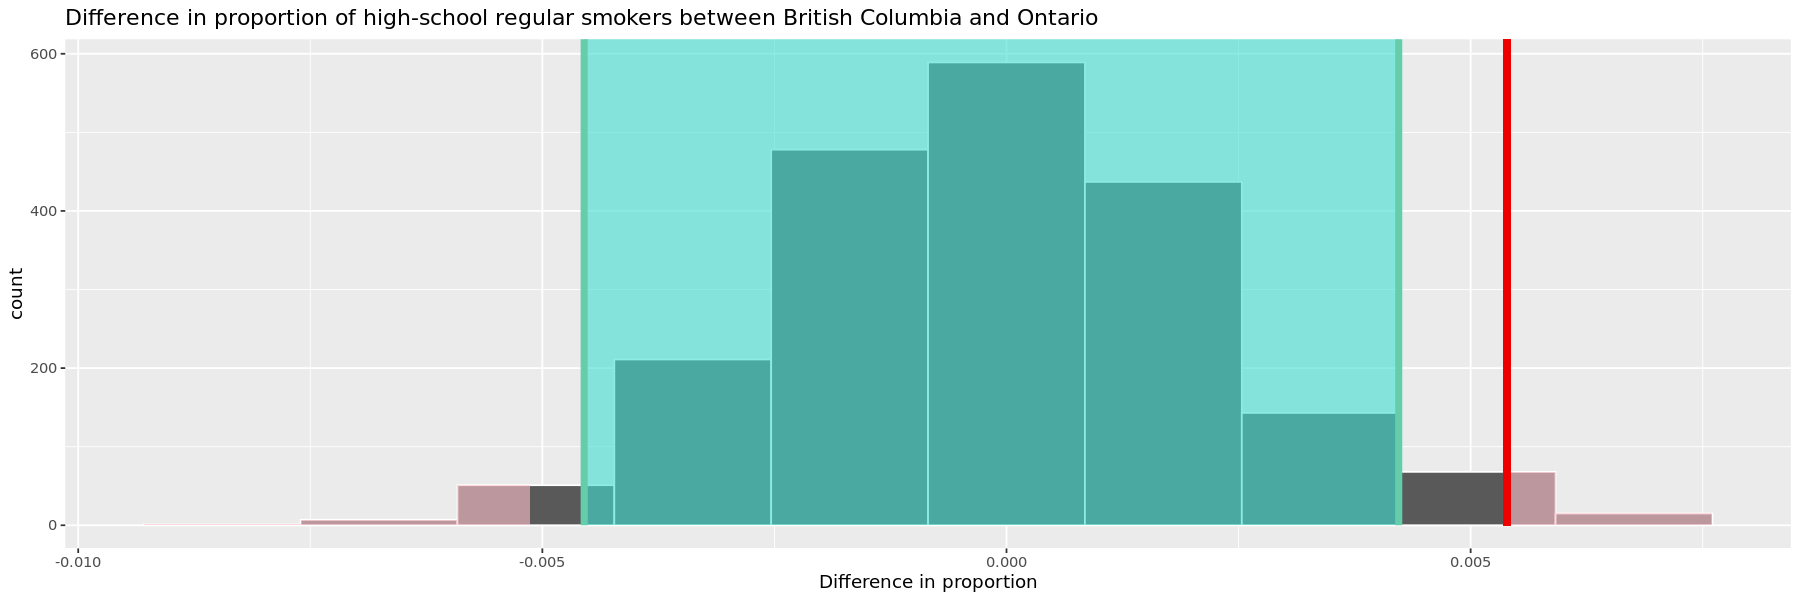

In [21]:
plot_with_ci <- null_result_plot +
shade_confidence_interval(endpoints = percentile_ci)
plot_with_ci

#### Why further analysis is required
The point estimate found above tells there is a difference in the true proportions. However, it doesn't take into consideration the standard error associated with the sample we used, i.e., the sample we obtained may not be representative because the true population might have great variability and different samples would give drastically different results.

Therefore, we cannot report the value above. Instead, in the next section we'll use Hypothesis Testing and Confidence Intervals to estimate our sample's degree of uncertainly and provide a more reliable result.

## Evaluation

#### Expectations
We expect the true proportion difference to be a small value because our graph above and the point estimate show that there's a little difference between the sample proportions.

#### Future questions
Others can extend our research question by comparing the proportions of high-school smoking students between other Canadian provinces.
Using data obtained from such a study would let us know if we can extrapolate the data for students throughout Canada using this study, or if the data is not representative which would disallow extrapolation as a method. 

## References
Burton, Suzan, et al. “‘Smoking Is Bad, It’s Not Cool…yet
I’m Still Doing It’: Cues for Tobacco Consumption in a ‘Dark’ Market.” *Journal
of Business Research*, vol. 68, no. 10, 1 Oct. 2015, pp. 2067–2074,
www.sciencedirect.com/science/article/pii/S0148296315001186, 10.1016/j.jbusres.2015.03.004.
Accessed 14 Dec. 2021.

Canada, Health, and PROPEL Centre for Population Health
Impact. “2018/2019 Canadian Student Tobacco, Alcohol and Drugs Survey.” *Abacus.library.ubc.ca*,
18 Nov. 2020, abacus.library.ubc.ca/dataset.xhtml?persistentId=hdl:11272.1/AB2/WEFOHY.
Accessed 1 Mar. 2022.

Johnson, Joy L., et al. “Socio-Demographic Correlates of
Cigarette Smoking among High School Students.” *Canadian Journal of Public
Health*, vol. 95, no. 4, July 2004, pp. 268–271, 10.1007/bf03405129.
Accessed 5 May 2020.

Reitsma, Angela H., and Steve Manske. “Smoking in Ontario
Schools.” *Canadian Journal of Public Health*, vol. 95, no. 3, May 2004,
pp. 214–218, 10.1007/bf03403652. Accessed 29 Oct. 2019.

**Word Count: 623**